This code reproduces the figures from

## "Plasmonic sensors beyond the phase matching condition: a simplified  approach" 

By Alessandro Tuniz, Alex Y. Song, Giuseppe Della Valle, and C. Martijn de Sterke 

Submitted to MDPI Sensors (2022)

For research purposes only.

Please cite the above paper if using any portion of this code for your research.

Creative Commons License (LICENSE-CC-BY-NC-SA).

Written by Alessandro Tuniz


## Paper Abstract: 

The conventional approach to optimising plasmonic sensors is typically based
entirely on ensuring phase matching between the excitation wave and the surface 
plasmon between two semi-infinite media. However, this leads to suboptimal 
performance, even in the conventional Otto geometry. We present a simplified 
coupled mode theory approach for evaluating and optimizing the sensing properties 
of plasmonic waveguide refractive index sensors. It only requires the calculation 
of propagation constants, without the need for calculating overlap integrals.  
We apply out method by evaluating the wavelength-, device length- and 
refractive index-dependent transmission spectra for an example silicon-on-insulator-based 
sensor of finite length. This reveals all salient spectral features which are 
consistent with full-field finite element calculations. This work provides a 
rapid and convenient framework for designing dielectric-plasmonic sensor prototypes.

In [1]:
import numpy as np
import matplotlib
import scipy as sp
import IPython

print(f'Numpy {np.__version__}')
print(f'Matplotlib {matplotlib.__version__}')
print(f'SciPy {sp.__version__}')
print(f'IPython {IPython.__version__}')

Numpy 1.21.5
Matplotlib 3.5.3
SciPy 1.9.3
IPython 8.6.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
import scipy as sp
from scipy.optimize import fsolve
from mpmath import mp
from IPython.display import clear_output
import os
import sys
import time
from IPython.display import display, clear_output
import matplotlib as mpl
import importlib as importlib
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.io import savemat, loadmat
import importlib as importlib
# if you need to reload "sensors": 
# importlib.reload(sensors)

# some global variables

global e0 
global c0

e0 = 8.85418787162e-12 # permittivity of free space
c0 = 299792458 # speed of light


In [6]:
sys.path.insert(1, 'functions/')
sys.path.insert(1, 'data/')

# derivative function
from derivative import derivative 
# material functions    
from gold_permittivity import gold_permittivity
from silica_permittivity import silica_permittivity
import sensors as sensors # all the important functions are in here


In [7]:
# Introductory notes.
# Polarization: TM

# Slabs of thickness di and material permittivity e_i and thickness d_i are distributed along x as follows:

# Thickness d1,d2,e3 and permittivity e1,e2,e3,e4,e5 a follows:    

# infinite    | d1 | d2 | d3 | infinite 
# -----------|----|----|----|----------
#  e1        | e2 | e3 | e4 | e5       
# 
# ---------------------------------------> x 

# y is "out of plane" (1D mode, so it's infinite): this is a TM mode, so we have only Hy 
# x is perpendicular to the interface: this is TM mode, se Ex is the dominant electric field component
# z is the direction of propagation: this is a TM mode, so we have an Ez component

In [8]:
# define wavelength range
N_points = 250 # number of points in wavelength range 
wavelength_range = np.linspace(1300e-9,1900e-9,N_points) # wavelength range

# define analyte index range
dn = 0.005 # refractive index interval, fine

analyte_index_range = np.arange(1.5,1.298,-dn)


100.0% complete


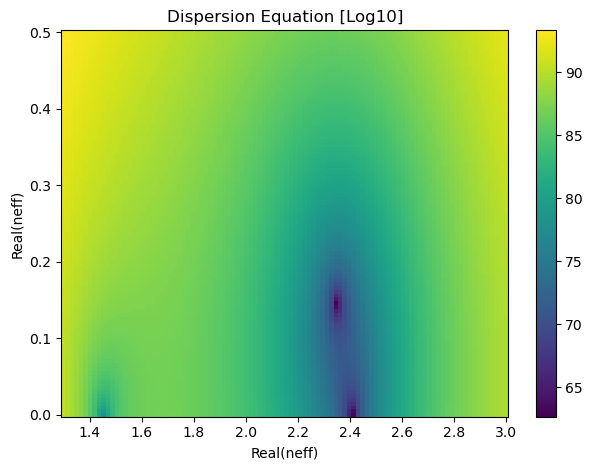

In [9]:
# calculate/check effective index/fields for the first wavelength and analyte
# to find the mode you're looking for

lm = wavelength_range[0]       # first wavelength
k0 = 2*np.pi/lm                # wavenumber

# consider example in paper

# define a material permittivity distribution 
e1 = silica_permittivity(lm)
e2 = 3.5**2
e3 = silica_permittivity(lm)
e4 = gold_permittivity(lm)
e5 = analyte_index_range[0]**2

# define slab thicknesses [m]
d1 = 220e-9
d2 =  400e-9
d3 = 7.5e-9

# spatial resolution for plotting
dx = 2.5e-9

# beware, these parameters global parameters 
global d1, d2, d3, dx

# package it all neatly
data = k0, e1, e2, e3, e4, e5, d1, d2, d3

# range of real and imaginary index where we plot complex transcendental equation to look for zeros
neffr = np.linspace(1.3,3,100) # real
neffi = np.linspace(0,0.5,100) # imaginary

# show dispersion equation, we look for zeros
sensors.show_dispersion_equation(neffr,neffi,k0, e1, e2, e3, e4, e5, d1, d2, d3)


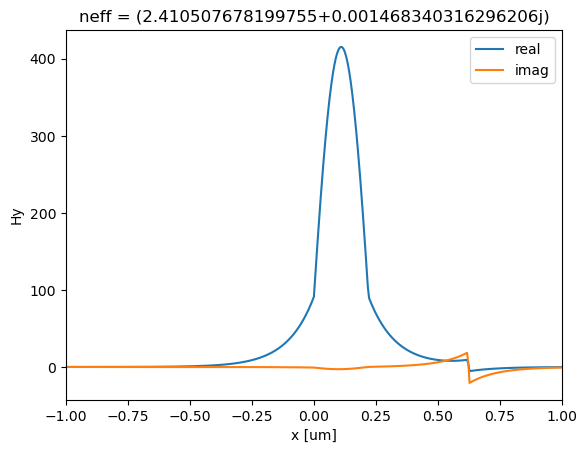

In [10]:
# Let's look at one mode, as an example

# guess effective index 
neff_guess = 2.4+0.001*1j # supermode 1
#neff_guess = 2.4+0.15*1j   # supermode 2

# take the first wavelength first
first_wavelength = wavelength_range[0]

x, Hy, Ex, Ez, neff0 = sensors.mode_solver_plot(first_wavelength,neff_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)


This code loops over all analyte indeces and wavelength defined above, and finds the effective index in each case

We can then use this to get the resonant spectra of a plasmonic device of length *L* as a function of wavelength, 
for each analyte, using coupled mode theory (CMT), which *only* uses mode calculations, but still accounts for mode interactions in the device

As described in the paper, we need:

1) The isolated modes

    i) lossless
    
    ii) lossy
    
    
2) The coupled super-modes
    
    i) lossless
    
    ii) lossy
    
    
So we first need to make sure that the *first* wavelength/analyte index combination looks right...
Once that's done, we loop over analytes and wavelength

In [11]:
# allocate all the indeces needed for the full calculation, which varies both wavelength and analyte refractive index
neff_0 = sensors.allocate_index(analyte_index_range,wavelength_range)
neff_s =  sensors.allocate_index(analyte_index_range,wavelength_range)
neff_s_ll =  sensors.allocate_index(analyte_index_range,wavelength_range)
neff_1 =  sensors.allocate_index(analyte_index_range,wavelength_range)
neff_2 =  sensors.allocate_index(analyte_index_range,wavelength_range)
neff_1_ll =  sensors.allocate_index(analyte_index_range,wavelength_range)
neff_2_ll =  sensors.allocate_index(analyte_index_range,wavelength_range)


In [12]:
# define first analyte index for clarity
first_analyte_index=analyte_index_range[0]
first_wavelength = wavelength_range[0]


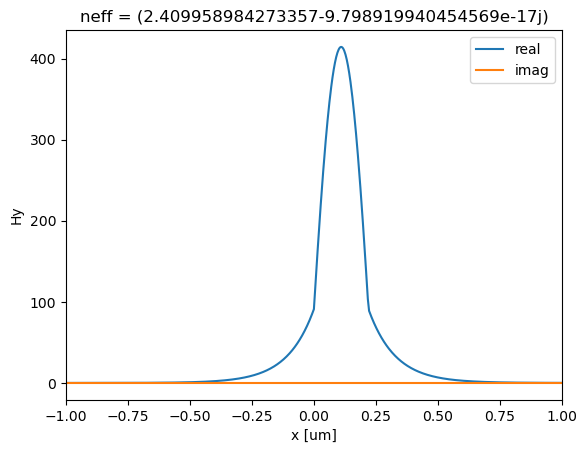

In [13]:
# calculate first isolated dielectric mode

# guess value for effective index
neff_guess = 2.45+1e-10*1j

# define permittivity
e1,e2,e3,e4,e5 = sensors.get_permittivity(first_wavelength,first_analyte_index,'dielectric isolated')

# calculate mode
x, Hy_0, Ex_0, Ez_0, neff_0[0,0] = sensors.mode_solver_plot(first_wavelength,neff_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)


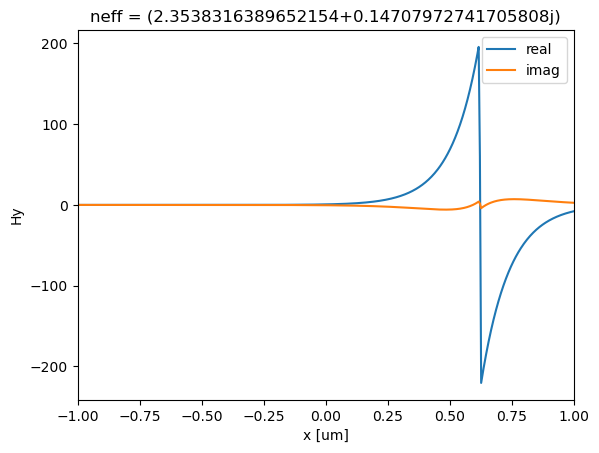

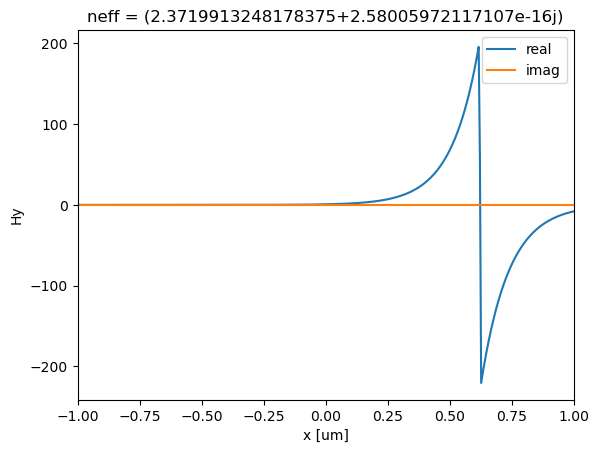

In [14]:
# calculate first isolated plamonic mode, lossy and lossless

# guess value for effective index
neff_guess =  2.1+0.1*1j

# define permittivity lossy
e1,e2,e3,e4,e5 = sensors.get_permittivity(first_wavelength,first_analyte_index,'plasmonic isolated lossy')
# calculate mode lossy
x, Hy_s, Ex_s, Ez_s, neff_s[0,0] =  sensors.mode_solver_plot(first_wavelength,neff_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)

# define permittivity lossless
e1,e2,e3,e4,e5 = sensors.get_permittivity(first_wavelength,first_analyte_index,'plasmonic isolated lossless')
# calculate mode lossless
x, Hy_s_ll, Ex_s_ll, Ez_s_ll, neff_s_ll[0,0] =  sensors.mode_solver_plot(first_wavelength,neff_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)


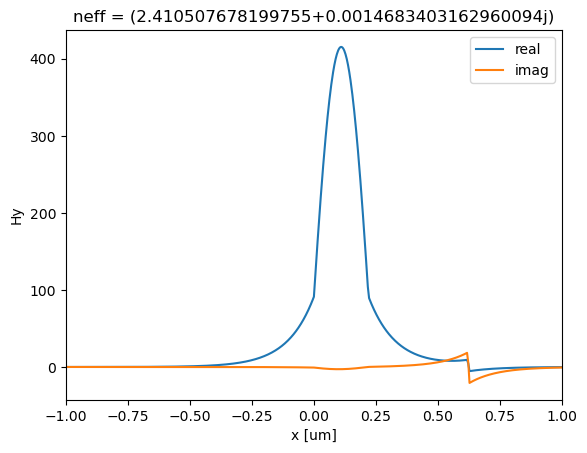

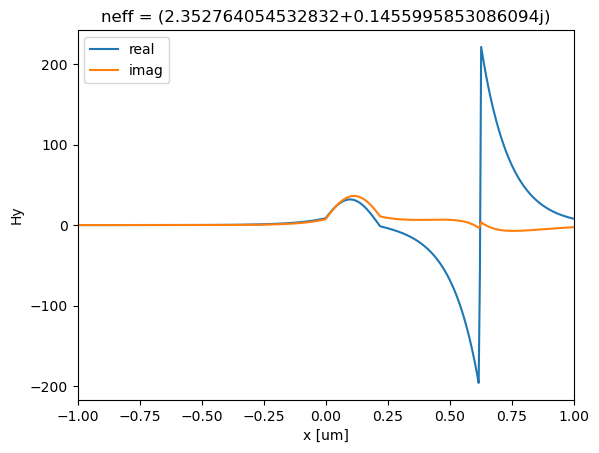

In [15]:
# calculate first two supermodes, lossy, get guess value from isolated modes..
neff_guess_1 = neff_0[0,0]
neff_guess_2 = neff_s[0,0]

e1,e2,e3,e4,e5 = sensors.get_permittivity(first_wavelength,first_analyte_index,'supermode lossy')
x, Hy_1, Ex_1, Ez_1, neff_1[0,0] =  sensors.mode_solver_plot(first_wavelength,neff_guess_1,e1,e2,e3,e4,e5,d1,d2,d3,dx)
x, Hy_2, Ex_2, Ez_2, neff_2[0,0] =  sensors.mode_solver_plot(first_wavelength,neff_guess_2,e1,e2,e3,e4,e5,d1,d2,d3,dx)


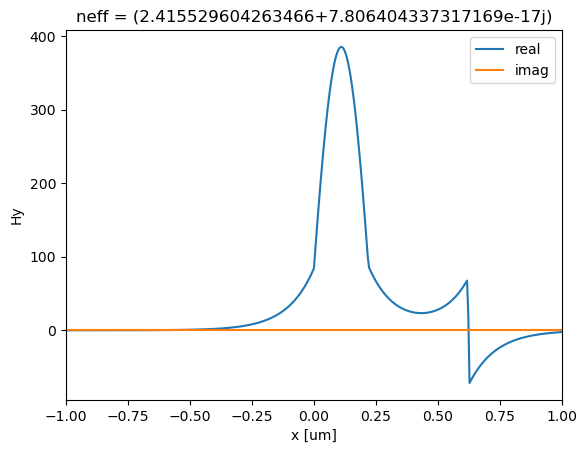

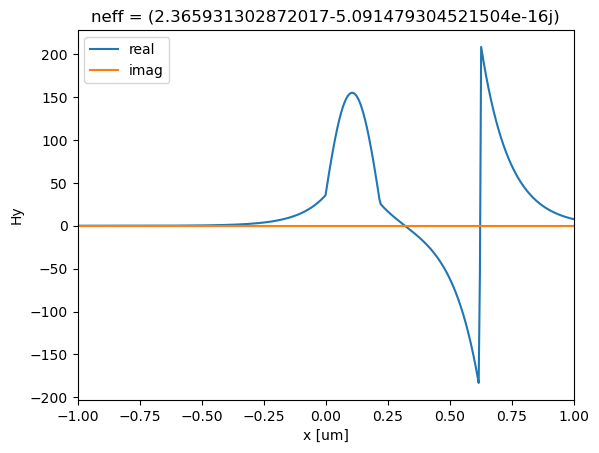

In [16]:
# calculate first two supermodes, lossless, get guess value from isolated modes..
neff_guess_1 = neff_0[0,0]
neff_guess_2 = neff_s[0,0]

e1,e2,e3,e4,e5 = sensors.get_permittivity(first_wavelength,first_analyte_index,'supermode lossless')
x, Hy_1_ll, Ex_1_ll, Ez_1_ll, neff_1_ll[0,0] =  sensors.mode_solver_plot(first_wavelength,neff_guess_1,e1,e2,e3,e4,e5,d1,d2,d3,dx)
x, Hy_2_ll, Ex_2_ll, Ez_2_ll, neff_2_ll[0,0] =  sensors.mode_solver_plot(first_wavelength,neff_guess_2,e1,e2,e3,e4,e5,d1,d2,d3,dx)



In [17]:
# BIG CALCULATION: get all the modes you need, all wavelengths, all analyte indeces

# dielectric lossless isolated
neff_0 =    sensors.loop_over_analytes_and_wavelength(wavelength_range,analyte_index_range,neff_0,d1, d2, d3,'dielectric isolated')
# plasmonic lossy isolated
neff_s =    sensors.loop_over_analytes_and_wavelength(wavelength_range,analyte_index_range,neff_s,d1, d2, d3,'plasmonic isolated lossy')
# plasmonic lossless isolated
neff_s_ll = sensors.loop_over_analytes_and_wavelength(wavelength_range,analyte_index_range,neff_s_ll,d1, d2, d3,'plasmonic isolated lossless')
# coupled supermodes lossy
neff_1 =    sensors.loop_over_analytes_and_wavelength(wavelength_range,analyte_index_range,neff_1,d1, d2, d3,'supermode lossy')
neff_2 =    sensors.loop_over_analytes_and_wavelength(wavelength_range,analyte_index_range,neff_2,d1, d2, d3,'supermode lossy')
# coupled supermodes lossless
neff_1_ll = sensors.loop_over_analytes_and_wavelength(wavelength_range,analyte_index_range,neff_1_ll,d1, d2, d3,'supermode lossless')
neff_2_ll = sensors.loop_over_analytes_and_wavelength(wavelength_range,analyte_index_range,neff_2_ll,d1, d2, d3,'supermode lossless')


looping over analyte index... 100.0% complete


## Fig. 6


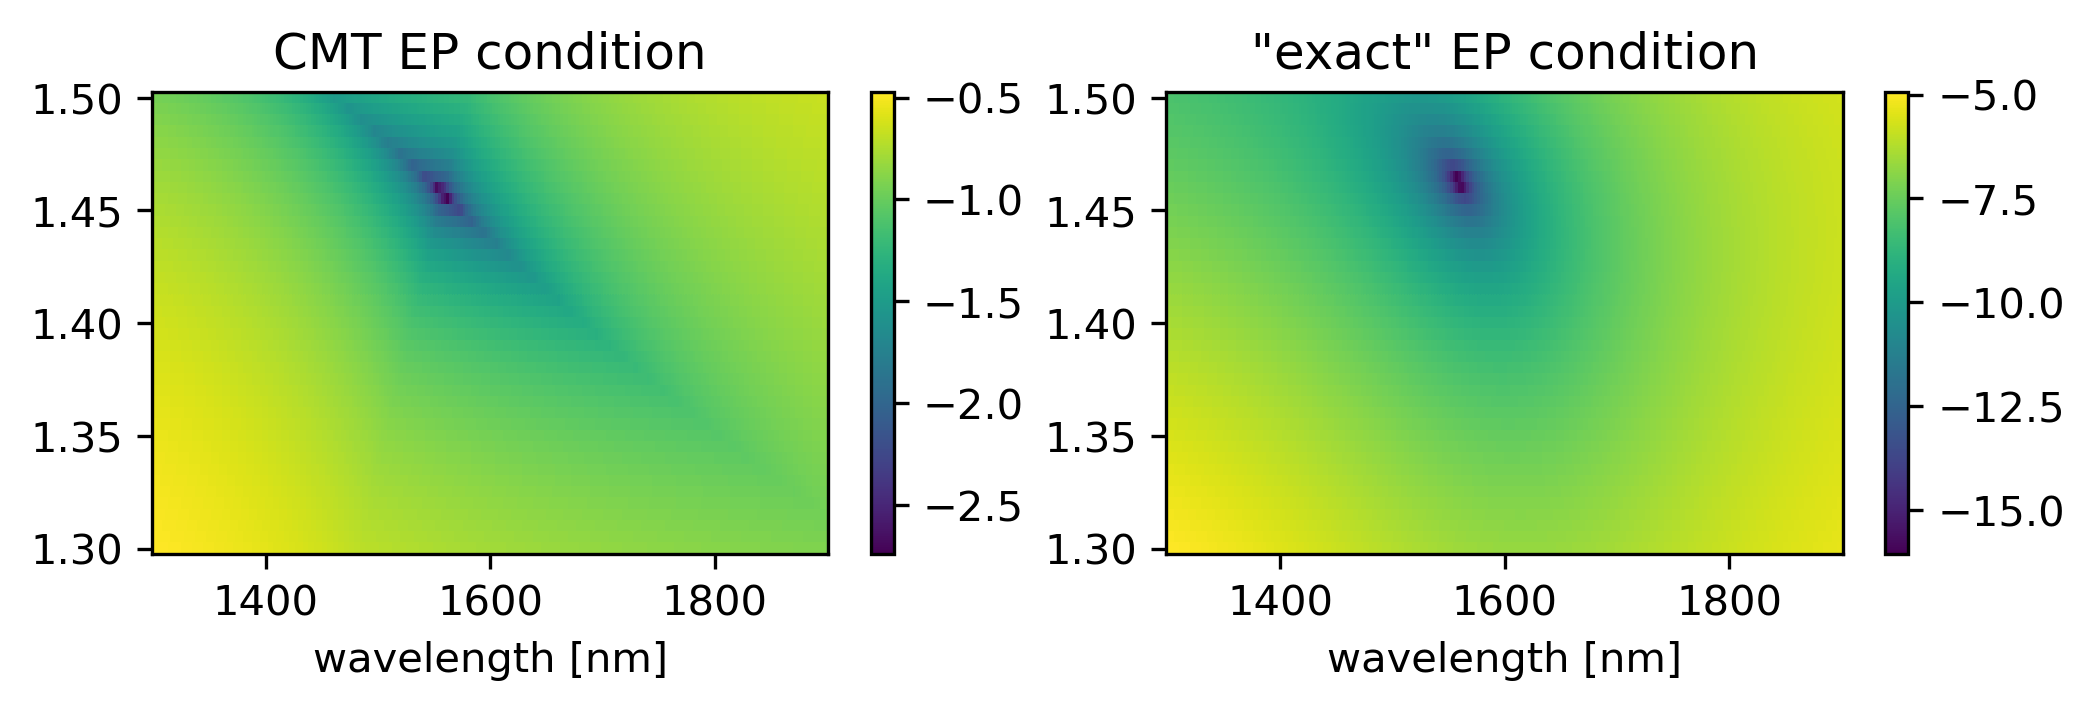

In [18]:
# get the kappa, and the associated supermodes effective index predicted by CMT
kappa, neff_1_CMT, neff_2_CMT = sensors.get_kappa_and_neff_predicted_by_CMT(wavelength_range,neff_0,neff_s,neff_s_ll,neff_1,neff_2,neff_1_ll,neff_2_ll)
EP_exact, EP_CMT = sensors.plot_Fig_6(wavelength_range,analyte_index_range,neff_0,neff_s,neff_s_ll,neff_1,neff_2,neff_1_ll,neff_2_ll,kappa, neff_1_CMT, neff_2_CMT)

## Fig. 3 with analyte index as needed

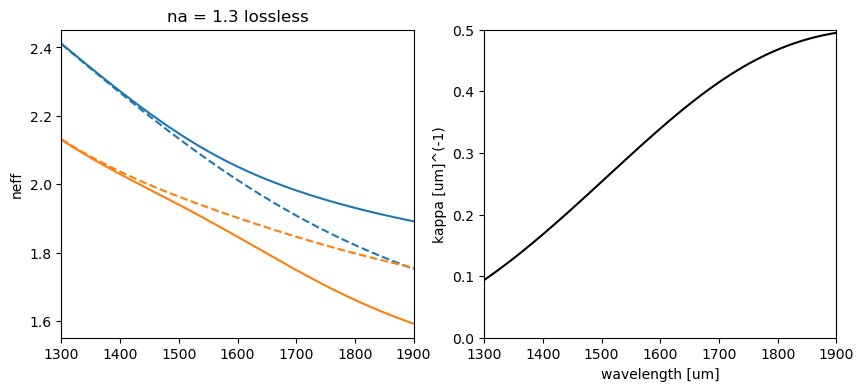

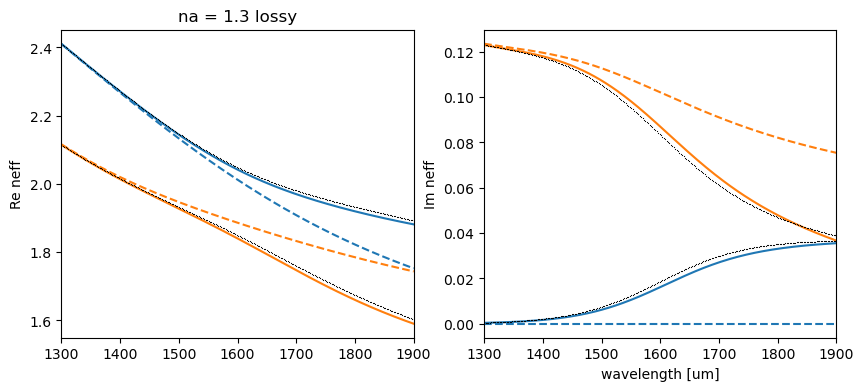

In [31]:
analyte_index_to_plot =  [1.3] # pick your analyte index, e.g,. 1.3, 1.4, 1.5

for plot_analyte_index in analyte_index_to_plot:
    sensors.plot_dispersion_lossless(plot_analyte_index,wavelength_range,analyte_index_range,neff_0,neff_s_ll,neff_1_ll,neff_2_ll,kappa)
    
for plot_analyte_index in analyte_index_to_plot:
    sensors.plot_dispersion_lossy(plot_analyte_index,wavelength_range,analyte_index_range,neff_0,neff_s,neff_1,neff_2,neff_1_CMT,neff_2_CMT)

## Fig. 7

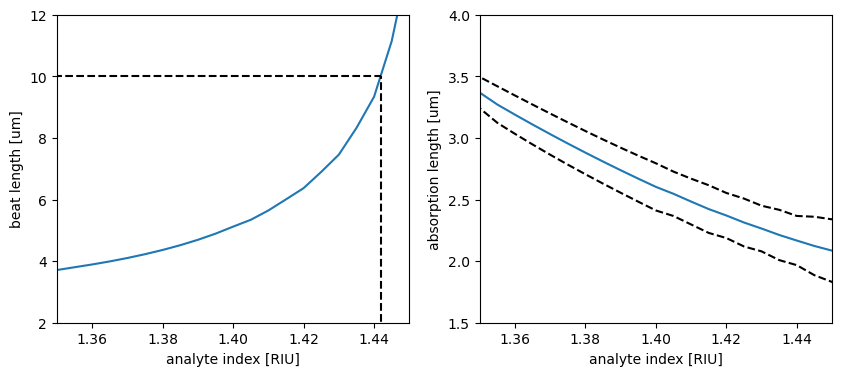

In [32]:
loss_length_1, loss_length_2, beat_length_exact, lm_pm_lossy = sensors.get_and_plot_characteristic_lengths(analyte_index_range,wavelength_range,neff_0,neff_s,neff_1,neff_2)

## Fig. 7a

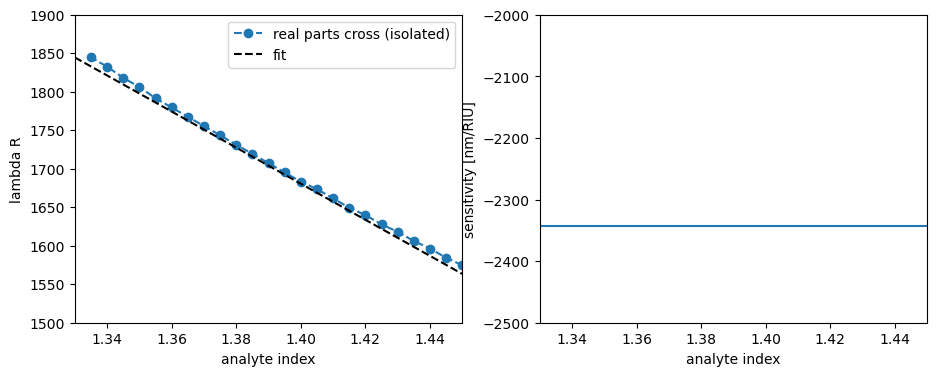

Sensitivity is -2343.4258774235395nm/RIU


In [33]:
# choose a range to plot resonance wavelength, FWMH, and FOM
na_min = 1.33
na_max = 1.45

na_range_sensitivity, sensitivity_lm_pm_lossy_poly = sensors.sensitivity_fit_and_plot(na_min,na_max,analyte_index_range, lm_pm_lossy)

In [34]:
# time to do full CMT and analysis on long device and with all the analyte indeces!
# Solve ODE, inspired by: https://stackoverflow.com/questions/48428140/imitate-ode45-function-from-matlab-in-python\n"

L_CMT = 50e-6 # maximum length for use in coupled mode theory
N_CMT = 51;  # number of points in propagation array 'z'

##
z0, z1 = 0, L_CMT                    # start and end
z = np.linspace(z0, z1, N_CMT)+0*1j  # the points of evaluation of solution
##

# allocate transmission spectrum as a function of analyte index and wavelength
T_CMT = np.zeros([len(analyte_index_range),len(z),len(wavelength_range)])+0*1j

# loop over analyte...
for ka in range(0,len(analyte_index_range)):  
    # loop over wavelength...
    for kn in range(0,wavelength_range.size):
        clear_output(wait=True)
        print("patience.. CMT approach running.. " + str(float(ka+1)/float(analyte_index_range.size)*100)+" % analytes complete "+ str(float(kn+1)/float(wavelength_range.size)*100)+" % wavelengths complete")
        # define familiar variables to put into couple mode theory
        coupling_coefficient_lossless =  kappa[ka,kn] # coupling coefficient from real part calculation
        beta_dielectric_isolated = 2*np.pi/wavelength_range[kn]*neff_0[ka,kn] # dielectric mode (always lossless)
        beta_plasmonic_isolated_lossy = 2*np.pi/wavelength_range[kn]*neff_s[ka,kn] # plasmonic mode (lossy)
        T_CMT[ka,:,kn] = sensors.coupled_mode_theory(z,beta_dielectric_isolated,beta_plasmonic_isolated_lossy,coupling_coefficient_lossless)
        

patience.. CMT approach running.. 100.0 % analytes complete 100.0 % wavelengths complete


In [35]:
# load COMSOL data, separately calculated and saved as .mat file...
lm_comsol, na_comsol, L_comsol, T_comsol = sensors.load_comsol_data()


## Plot Fig. 5


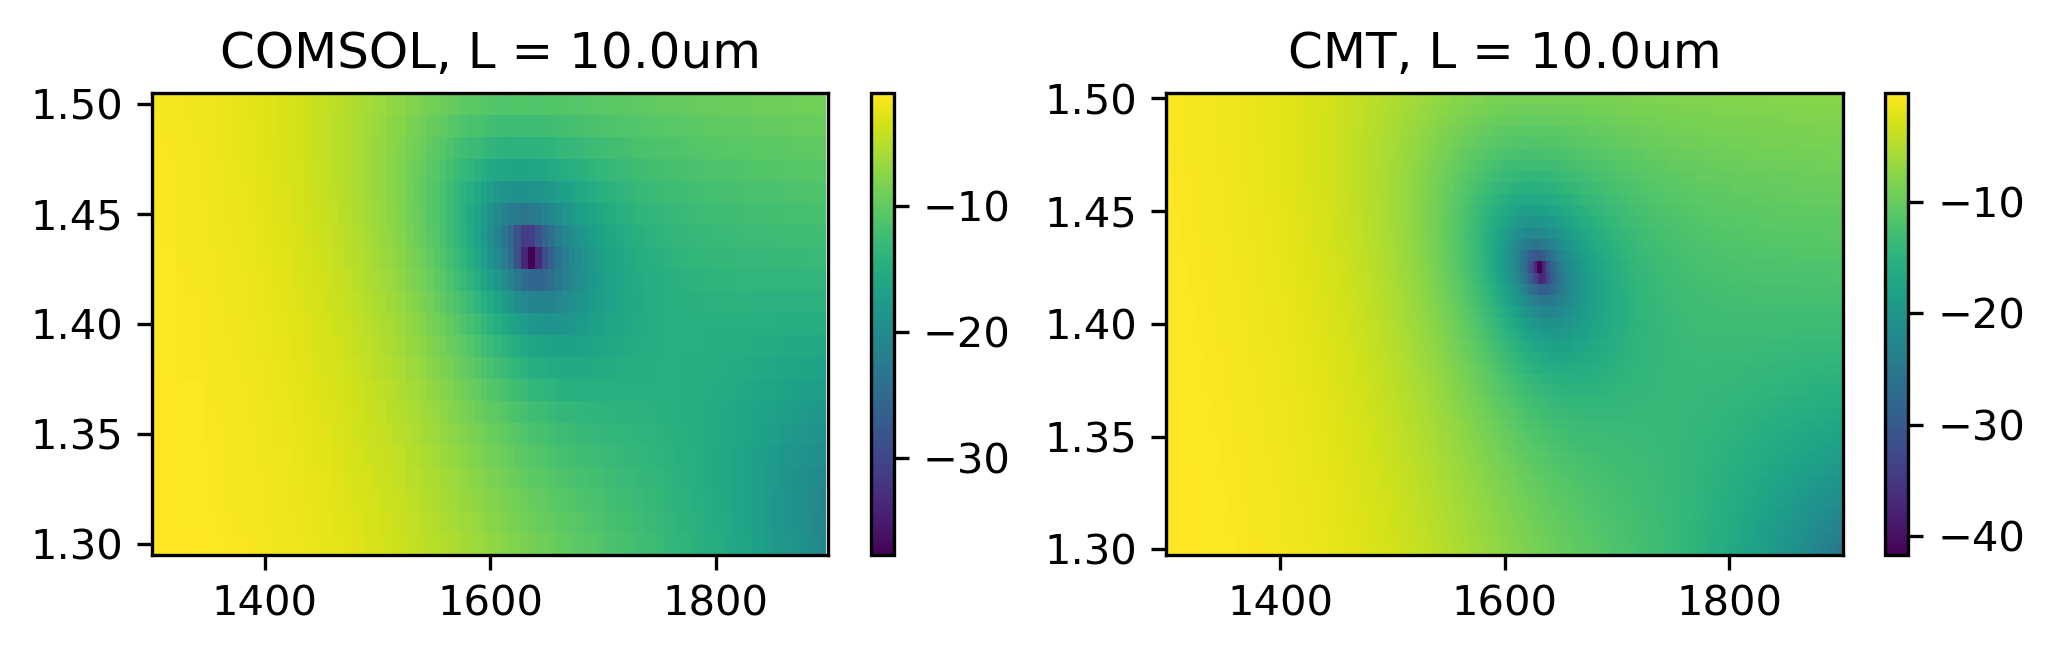

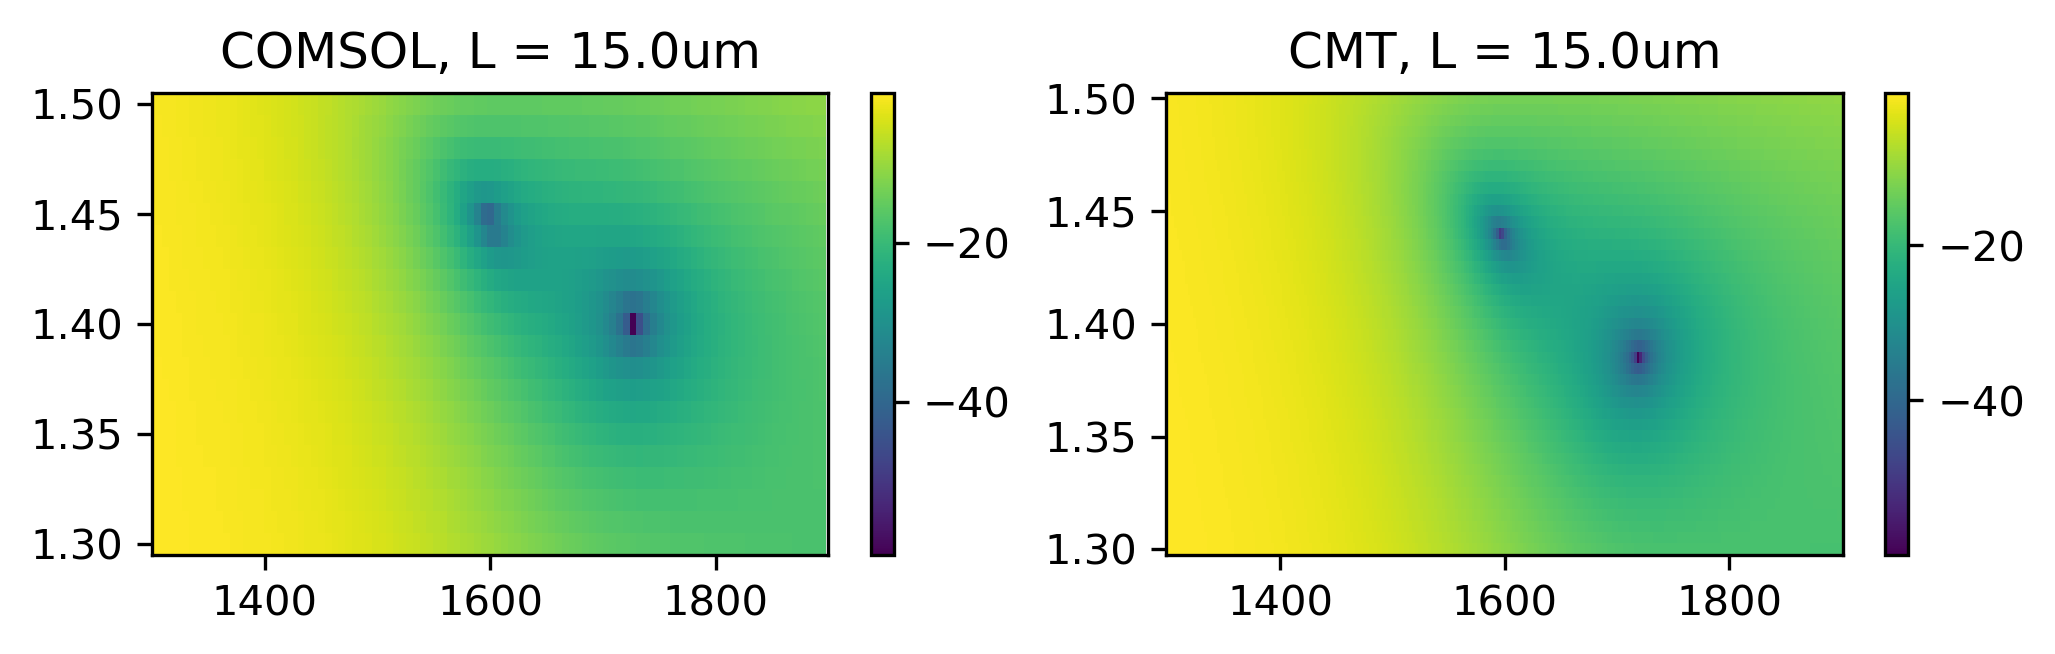

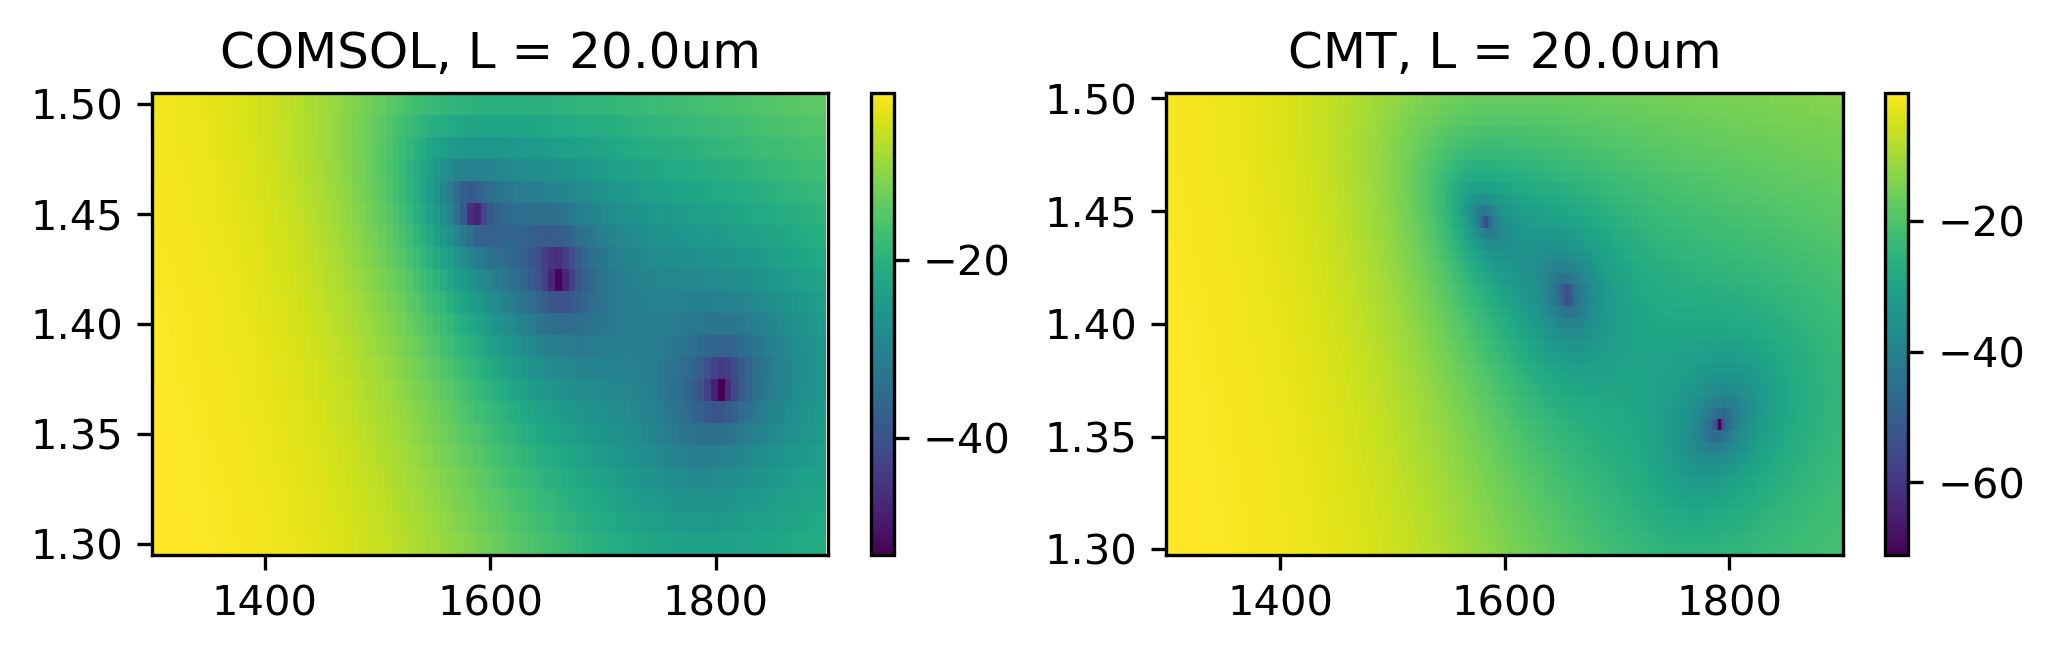

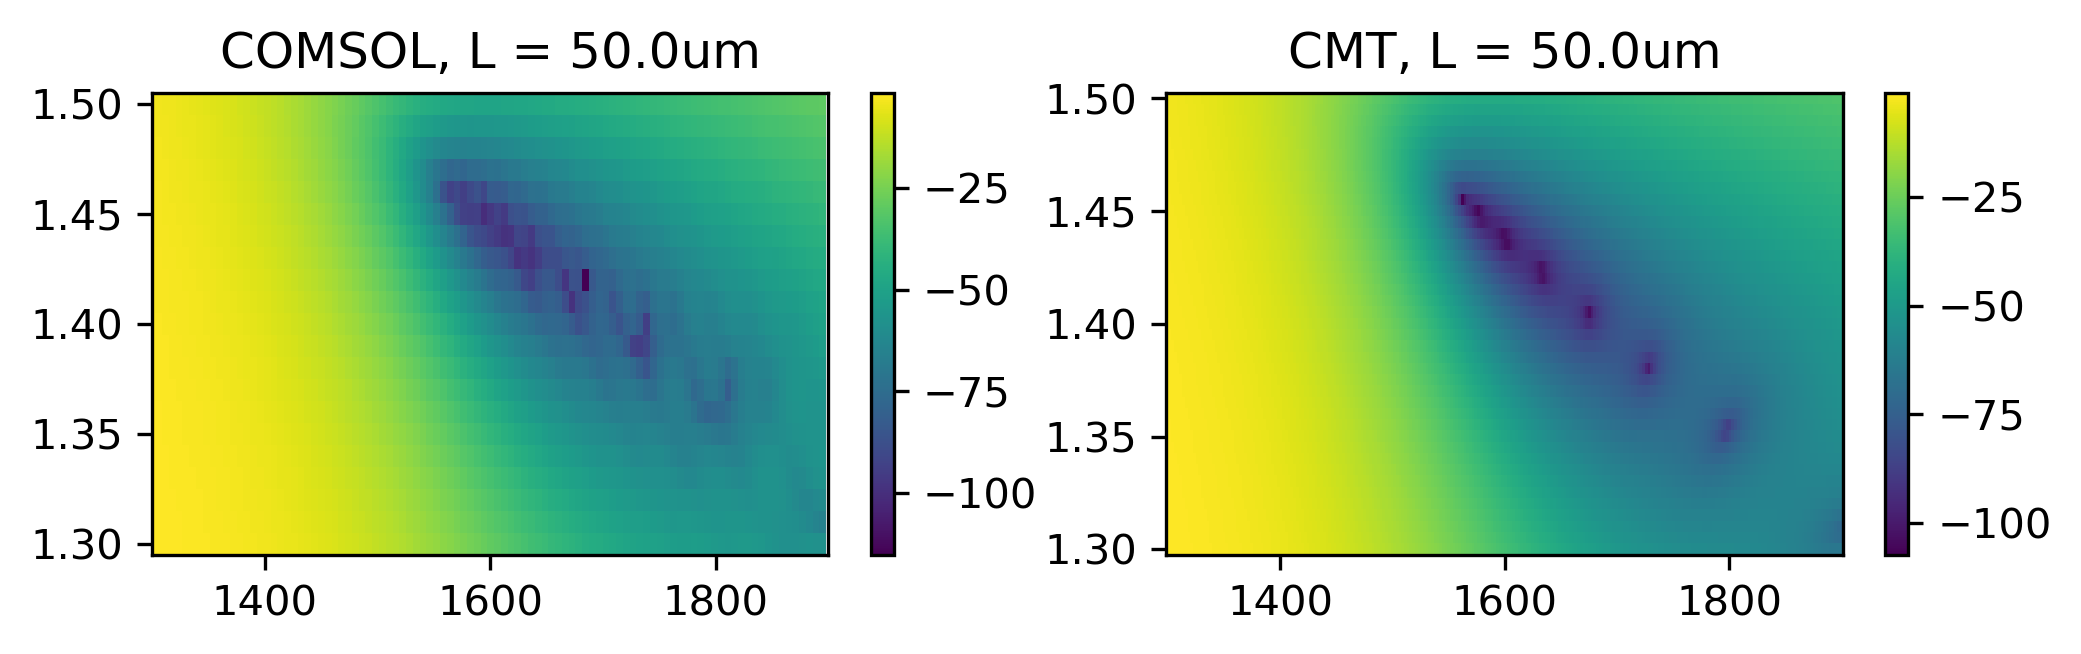

In [36]:
sensors.plot_CMT_COMSOL(lm_comsol,na_comsol,L_comsol,T_comsol,wavelength_range,analyte_index_range,z,T_CMT)


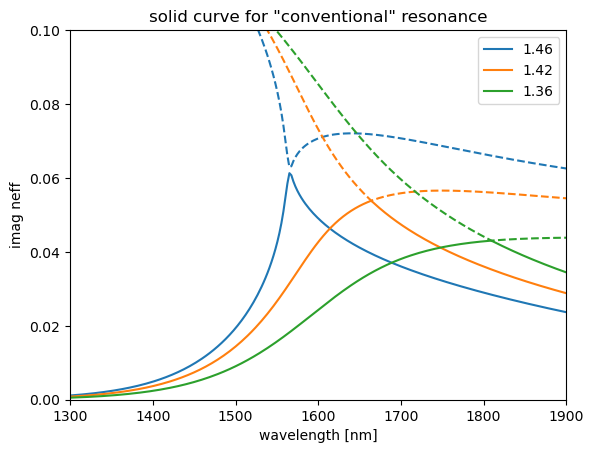

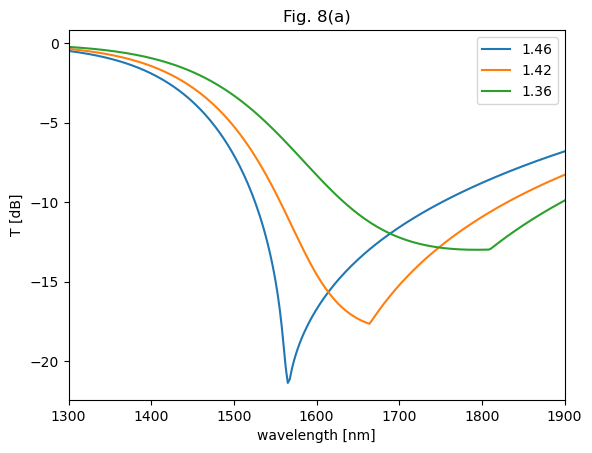

In [37]:
# calculate T_conventional for L=10um
L_propagate = 10e-6
#but only what you need...
index_range_to_plot = np.array([1.46, 1.42, 1.36])
# calculate + plot it
T_conventional = sensors.conventional_approach(L_propagate,index_range_to_plot,wavelength_range,analyte_index_range,neff_1,neff_2)

We now use a function "find_FWHM" that finds the wavelength of the transmission minimum and the FWHM 
(i.e., 3dB above the transmission minimum).

Input is wavelength and T (in dB) output is resonance wavelength lm_min, FWHM, and index of the minimum.

Because the spectrum is not right/left symmetric, it works by finding the minimum, splitting the spectrum 
into left and right parts of that minimum, finding the Tmin+3dB point on each side, and getting the FWHM from that.


na = 1.4400000000000013
L=10um


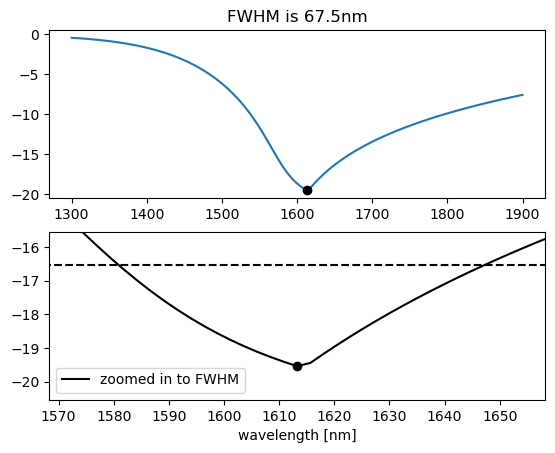

In [38]:
# try a few examples of T(dB), for chosen analyte/length  
# comment/uncomment below as needed

kl=10 # python index selecting device length for CMT case
ka=12 # index selecting analyte

#### conventional approach example, L_propagate=10um
T_temp = 10*np.log10(np.abs(np.squeeze(T_conventional)))[ka,:]
lm_temp = wavelength_range
print('na = ' + str(analyte_index_range[ka]))
print('L=10um')

#### CMT example
#T_temp = 10*np.log10(np.abs(T_CMT[ka,kl,:]))
#lm_temp = wavelength_range
#print('na = ' + str(analyte_index_range[ka]))
#print('L = ' + str(np.real(z[kl])/1e-6) + 'um')

#### FEM example
#T_temp = 10*np.log10(T_comsol[1,ka,:])
#lm_temp = lm_comsol
#print('na = ' + str(na_comsol[ka]))
#print('L = ' + str(np.real(L_comsol[1])/1e-6) + 'um')

# example plot to check that the output makes sense... note that number at the end:
# 1: plot
# 0: don't plot

lm_min_example, FWHM_example, index_min_example =  sensors.find_FWHM(lm_temp,T_temp,1)


## FOMs, Fig. 8

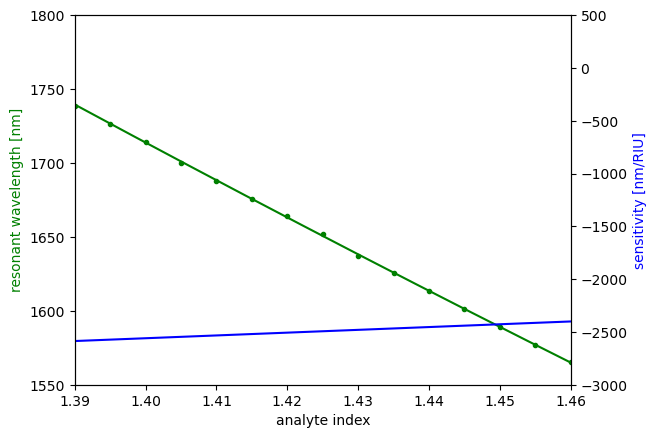

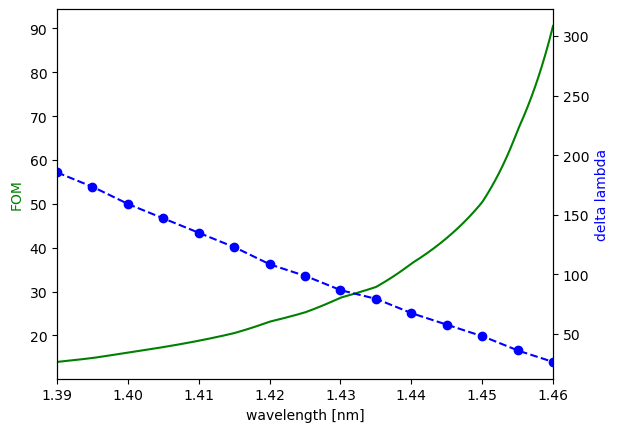

In [39]:
na_min = 1.39
na_max = 1.46

## conventional case calculated above for 10um...
sensors.plot_FOM(wavelength_range,analyte_index_range,T_conventional,na_min,na_max)



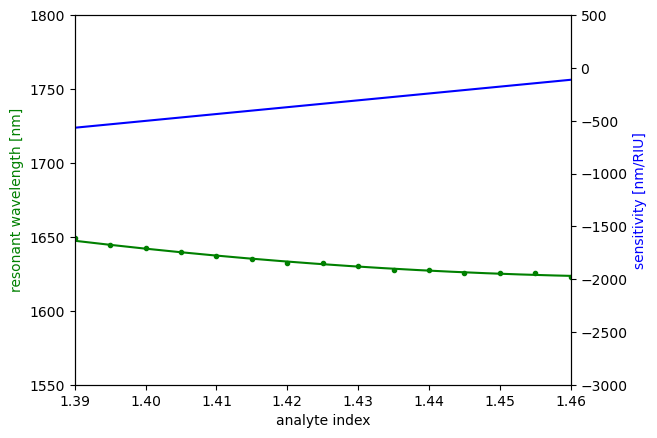

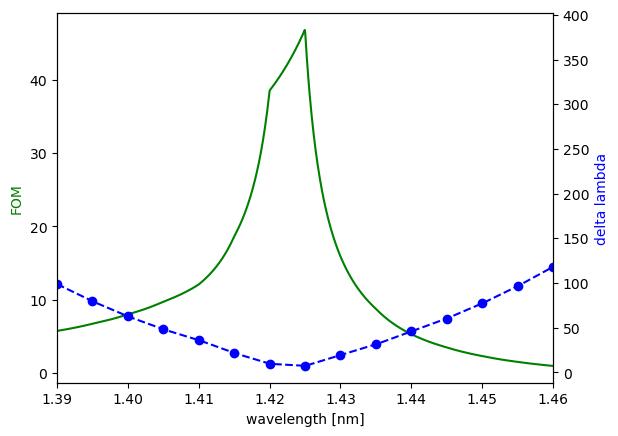

In [40]:
## CMT case
L_select= 10e-6 # select device length where you evaluate FOM
z = np.linspace(z0, z1, N_CMT)+0*1j  # the points of evaluation of solution
kl = (np.where(np.abs(L_select-z)==np.min(np.abs(L_select-z))))[0][0]
sensors.plot_FOM(wavelength_range,analyte_index_range,T_CMT[:,kl,:],na_min,na_max)


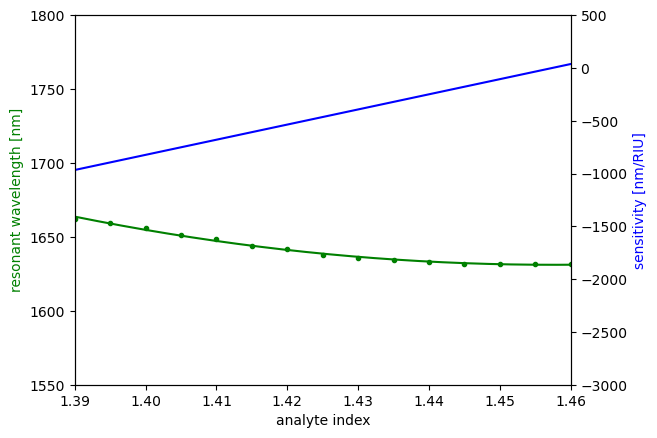

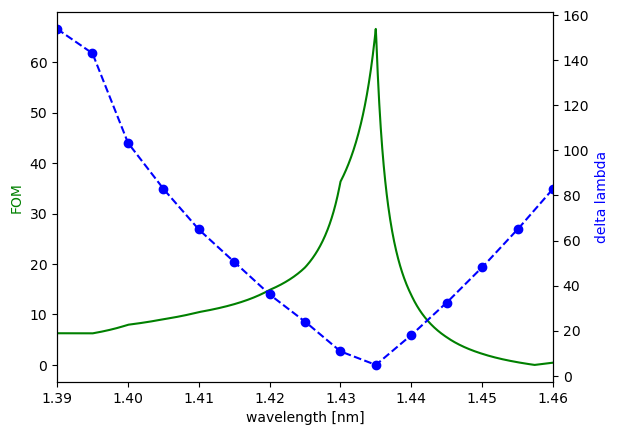

In [41]:
## COMSOL case
# import separate high resolution 10um COMSOL data..
temp= loadmat("data/sensor_data_400nm_sep_10um.mat")
L_comsol_10um = temp['L_range'][0]
T_comsol_10um = temp['T']
na_comsol_10um = temp['na_range'][0]
lm_comsol_10um = temp['lm_reduced'][0]

sensors.plot_FOM(lm_comsol_10um,na_comsol_10um,T_comsol_10um,np.min(na_comsol_10um),np.max(na_comsol_10um))

## APPENDIX:  solving coupled mode equations when you have all the neff


patience.. CMT approach running.. 100.0 % wavelengths complete


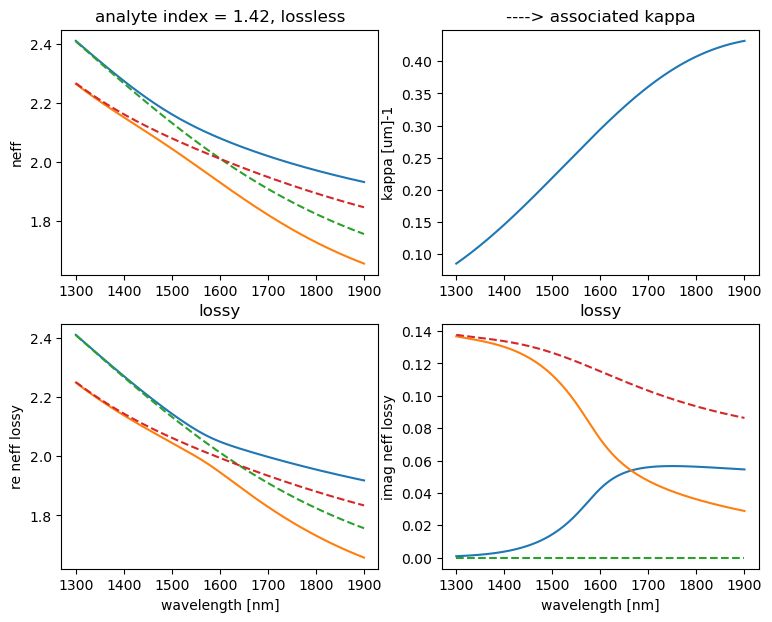

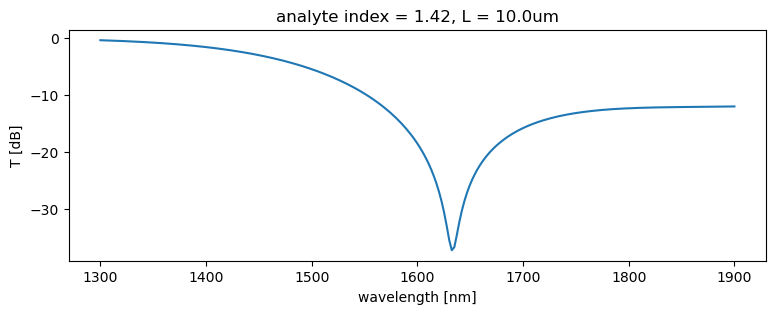

In [42]:
# choose an analyte scenario, in the case, na = 1.42

# import your own mode calculations if needed!!

na_choose = 1.42

wavelength_range    = wavelength_range       # for completeness when importing
analyte_index_range = analyte_index_range # for completeness when importing

# find the array index associated with this
ka_choose = int(np.where(np.abs(np.min(na_choose)-analyte_index_range)==np.min(np.abs(np.min(na_choose)-analyte_index_range)))[0])

# get the effective index of each mode in thelossless case
neff_lossless_dielectric = neff_0[ka_choose,:] # isolated dielectric
neff_lossless_plasmonic  = neff_s_ll[ka_choose,:] # isolated plasmonic lossless

# dielectric case doesn't have a lossy case
neff_lossy_plasmonic  = neff_s[ka_choose,:] # isolated plasmonic, lossy

neff_lossless_1 = neff_1_ll[ka_choose,:] # supermode 1 lossless
neff_lossless_2 = neff_2_ll[ka_choose,:] # supermode 2 lossless

neff_lossy_1 = neff_1[ka_choose,:] # supermode 1 lossless
neff_lossy_2 = neff_2[ka_choose,:] # supermode 2 lossless

# write the lossy modes as propagation constants for CMT 
k0 = (2*np.pi/wavelength_range) # free space wavenumber
beta1 = k0*neff_lossless_dielectric # isolated dielectric mode goes in CMT
beta2 = k0*neff_lossy_plasmonic # isolated plasmonic lossy mode goes in CMT

# get kappa from the above
DELTA = k0*(neff_lossless_1-neff_lossless_2)/2     # \tilde{\Delta} in Eq. (8) of the paper
delta = k0*(neff_lossless_dielectric-neff_lossless_plasmonic)/2     # \Delta in Eq. (8)  of the paper (lossless modes)
kappa_CMT = np.sqrt(DELTA**2-delta**2)  # \kappa in Eq. (8) from lossless case goes in CMT

# pick a length to propagate
L_device = 10e-6

# create the propagation array in z, here called ZZ, with array length NN=10 for speed
NN = 10
ZZ = np.linspace(0,L_device,NN)+0*1j


##  calculate the transmission with a simple function
## CMT calculates the field at every point in propagation Z
## therefore, we calculate Transmission_total(z) and then the transmission at the end of the device is the last element..
Transmission = np.zeros(len(wavelength_range))
for kn in range(0,len(wavelength_range)):
    clear_output(wait=True)
    print("patience.. CMT approach running.. " + str(float(kn+1)/float(wavelength_range.size)*100)+" % wavelengths complete")
    Transmission_total = sensors.coupled_mode_theory(ZZ,beta1[kn],beta2[kn],kappa_CMT[kn])
    Transmission[kn] = Transmission_total[-1]
    
## plot it all!

import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(9,7), dpi=100)
plt.subplot(2,2,1)
plt.plot(wavelength_range/1e-9,neff_lossless_1)
plt.plot(wavelength_range/1e-9,neff_lossless_2)
plt.plot(wavelength_range/1e-9,neff_lossless_dielectric,'--')
plt.plot(wavelength_range/1e-9,neff_lossless_plasmonic,'--')
plt.title('analyte index = ' + str(na_choose) + ', lossless')
plt.ylabel('neff')

plt.subplot(2,2,2)
plt.plot(wavelength_range/1e-9,kappa_CMT/1e6)
plt.title('----> associated kappa')
plt.ylabel('kappa [um]-1')

plt.subplot(2,2,3)
plt.plot(wavelength_range/1e-9,neff_lossy_1)
plt.plot(wavelength_range/1e-9,neff_lossy_2)
plt.plot(wavelength_range/1e-9,neff_lossless_dielectric,'--')
plt.plot(wavelength_range/1e-9,neff_lossy_plasmonic,'--')
plt.ylabel('re neff lossy')
plt.xlabel('wavelength [nm]')
plt.title('lossy')

plt.subplot(2,2,4)
plt.plot(wavelength_range/1e-9,np.imag(neff_lossy_1))
plt.plot(wavelength_range/1e-9,np.imag(neff_lossy_2))
plt.plot(wavelength_range/1e-9,np.imag(neff_lossless_dielectric),'--')
plt.plot(wavelength_range/1e-9,np.imag(neff_lossy_plasmonic),'--')
plt.ylabel('imag neff lossy')
plt.xlabel('wavelength [nm]')
plt.title('lossy')

plt.figure(figsize=(9,3), dpi=100)
plt.plot(wavelength_range/1e-9,10*np.log10(Transmission))
plt.title('analyte index = ' + str(na_choose) + ', L = '+ str(float('%.3g' % (L_device/1e-6))) + 'um')
plt.ylabel('T [dB]')
plt.xlabel('wavelength [nm]')

plt.show()
